In [46]:
import pickle
import pandas as pd
import numpy as np
import scanpy as sc
from torchmetrics.functional.text.rouge import rouge_score
from tqdm import tqdm

In [4]:
with open("prt_pca_umap.pkl", "rb") as f:
    adata = pickle.load(f)
split = pd.read_csv("split_0.csv", sep=",")
id_map = pd.read_csv('id_maps.tsv', sep="\t", header=None)
with open("uniref50_gpt_data.pkl", "rb") as f:
    pika = pickle.load(f)

In [10]:
adata.obs["cid"] = adata.obs[0].map({key: value for key, value in zip(id_map[0], id_map[2])})
adata.obs["split"] = adata.obs[0].map({key: value for key, value in zip(split["uniprot_id"], split["split"])})
adata = adata[adata.obs[0].isin(pika)]
adata.obs = adata.obs.reset_index(drop=True, inplace=False)

In [13]:
print("PCA")
sc.tl.pca(adata)
print("neighbour")
sc.pp.neighbors(adata)

PCA


/opt/pyenv/versions/3.10.12/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:229: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm['X_pca'] = X_pca


neighbour


/opt/pyenv/versions/3.10.12/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [50]:
scores = {}
for i, r in tqdm(adata.obs.iterrows(), total=len(adata)):
    uid, cid, sp = r
    if sp == "test":
        scores[uid] = 0
        rr = adata.obsp['distances'][i].toarray()[0]
        closest_indices = np.argsort(rr)[-10:]
        _sets = adata[closest_indices].obs
        _sets = _sets[_sets["split"] != "test"]
        s1 = pika[uid]['sequence']
        s2s = [pika[adata.obs[0].iloc[i]]['sequence'] for i in _sets.index]
        for ss in s2s:
            score = rouge_score(s1, ss, tokenizer=list, rouge_keys="rougeL")['rougeL_fmeasure'].item()
            if score > scores[uid]:
                scores[uid] = score
            if score > 0.5:
                break

100%|██████████| 257154/257154 [2:09:17<00:00, 33.15it/s]  


In [53]:
with open("test_sim_scores.pkl", "wb") as f:
    pickle.dump(scores, f)
    

{'bodies': [<matplotlib.collections.PolyCollection at 0x7f8eeaf45960>],
 'cmaxes': <matplotlib.collections.LineCollection at 0x7f8eeaf45870>,
 'cmins': <matplotlib.collections.LineCollection at 0x7f8eeaf45690>,
 'cbars': <matplotlib.collections.LineCollection at 0x7f8eeaf46200>}

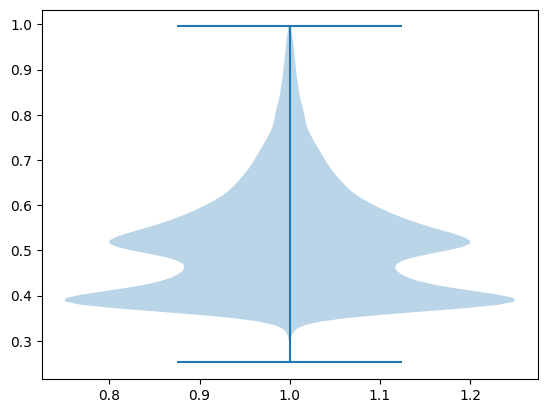

In [54]:
import matplotlib.pyplot as plt

plt.violinplot(scores.values())

In [55]:
esm2 = pd.read_csv("esm2_split.txt", header=None)

In [ ]:
esm2_eval = set([i.replace(">", "") for i in esm2[0]])
adata.obs["esm2"] = adata.obs["cid"].map(lambda x: "eval" if x in esm2_eval else "train")
adata.obs

In [82]:
import string
def harmonise_gpt_results(result: str) -> str:
    """Harmonise GPT responses to match expected format."""
    result_map = {"yes": "correct", "no": "incorrect", "wrong": "incorrect", "right": "correct"}
    result = result.translate(str.maketrans("", "", string.punctuation))
    result = result.split()[0].lower()
    return result_map.get(result, result)

def get_spli_scores(ad ,path="peachy_waterfall-seed.tsv"):
    preds = pd.read_csv(path, sep="\t")
    preds["esm2"] = preds["uniprot_id"].map({k: v for k, v in zip(ad.obs[0], ad.obs["esm2"])})
    for n, _df in preds.groupby("subject"):
        ev = _df[_df["esm2"] == "eval"]["results"].map(harmonise_gpt_results).value_counts(normalize=True).to_dict()
        tr = _df[_df["esm2"] == "train"]["results"].map(harmonise_gpt_results).value_counts(normalize=True).to_dict()
        print(n)
        print('eval', ev)
        print('train', tr)


In [83]:
get_spli_scores(adata)

catalytic activity
eval {'correct': 0.6271186440677966, 'incorrect': 0.3728813559322034}
train {'correct': 0.5793780687397708, 'incorrect': 0.4206219312602291}
cofactor
eval {'correct': 0.9596774193548387, 'incorrect': 0.04032258064516129}
train {'correct': 0.9706666666666667, 'incorrect': 0.024333333333333332, 'maybe': 0.005}
functional domains
eval {'correct': 0.7760736196319018, 'maybe': 0.11809815950920245, 'incorrect': 0.1058282208588957}
train {'correct': 0.786994915707787, 'maybe': 0.1263045223441263, 'incorrect': 0.0867005619480867}
subject
eval {}
train {}


In [84]:
get_spli_scores(adata, path="vocal-moon-44.tsv")

catalytic activity
eval {'correct': 0.6551724137931034, 'incorrect': 0.3448275862068966}
train {'correct': 0.5158730158730159, 'incorrect': 0.48412698412698413}
cofactor
eval {'correct': 0.9615384615384616, 'incorrect': 0.038461538461538464}
train {'correct': 0.9627118644067797, 'incorrect': 0.020338983050847456, 'maybe': 0.01694915254237288}
functional domains
eval {'correct': 0.7446153846153846, 'maybe': 0.16615384615384615, 'incorrect': 0.08923076923076922}
train {'correct': 0.7554655870445344, 'maybe': 0.1406207827260459, 'incorrect': 0.1039136302294197}
subject
eval {}
train {}


In [85]:
get_spli_scores(adata, path="desert_leaf-seed.tsv")

catalytic activity
eval {'incorrect': 0.574468085106383, 'correct': 0.425531914893617}
train {'incorrect': 0.5323624595469255, 'correct': 0.46763754045307443}
cofactor
eval {'correct': 0.953307392996109, 'incorrect': 0.0311284046692607, 'maybe': 0.01556420233463035}
train {'correct': 0.9518935516888434, 'incorrect': 0.037529853292391675, 'maybe': 0.010576595018764927}
functional domains
eval {'correct': 0.708079268292683, 'incorrect': 0.14939024390243902, 'maybe': 0.14253048780487804}
train {'correct': 0.7117080450413784, 'incorrect': 0.1474698141364808, 'maybe': 0.1408221408221408}
subject
eval {}
train {}
